Aim of the assignment
- To reach 99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement)
- Less than or equal to 20 Epochs (is can do in 15 better)
- Less than 10000 Parameters
- Do this in exactly 5 steps

### Target:

- Get the set-up right with parameters less than 10K
- Set Transforms
-  Set Data Loader
-  Set Basic Working Code
- Set Basic Training & Test Loop

## Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt # for visualisation
from tqdm import tqdm

## Data Transformations



In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
])

## Creating Train/Test 

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Dataloader Arguments

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


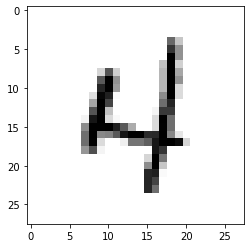

In [ ]:

# Visualising Images
dataset = iter(train_loader)
images, labels = dataset.next()

print(images.shape)
print(labels.shape)


plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


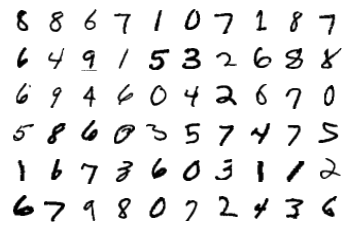

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Defining the model


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Params 


In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
--------------------------------

## Training and Testing

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.171647310256958 Batch_id=468 Accuracy=86.91: 100%|██████████| 469/469 [00:37<00:00, 12.53it/s]



Test set: Average loss: 0.0709, Accuracy: 9778/10000 (97.78%)

EPOCH: 1


Loss=0.02345419116318226 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:37<00:00, 12.51it/s]



Test set: Average loss: 0.0439, Accuracy: 9849/10000 (98.49%)

EPOCH: 2


Loss=0.05811501666903496 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]



Test set: Average loss: 0.0380, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.008012492209672928 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:37<00:00, 12.51it/s]



Test set: Average loss: 0.0305, Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.09363314509391785 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:37<00:00, 12.54it/s]



Test set: Average loss: 0.0262, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.004521720577031374 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:37<00:00, 12.55it/s]



Test set: Average loss: 0.0299, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.01575702615082264 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:37<00:00, 12.52it/s]



Test set: Average loss: 0.0284, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.0011563700390979648 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:37<00:00, 12.54it/s]



Test set: Average loss: 0.0268, Accuracy: 9910/10000 (99.10%)

EPOCH: 8


Loss=8.187795901903883e-05 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:37<00:00, 12.56it/s]



Test set: Average loss: 0.0304, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


Loss=0.0015095145208761096 Batch_id=468 Accuracy=99.82: 100%|██████████| 469/469 [00:37<00:00, 12.56it/s]



Test set: Average loss: 0.0253, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.0019395098788663745 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:37<00:00, 12.52it/s]



Test set: Average loss: 0.0293, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.0034592943266034126 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]



Test set: Average loss: 0.0286, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.0008882636320777237 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:37<00:00, 12.53it/s]



Test set: Average loss: 0.0303, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.0002032176562352106 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:37<00:00, 12.53it/s]



Test set: Average loss: 0.0307, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.01875772513449192 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]



Test set: Average loss: 0.0309, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.0022081320639699697 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:37<00:00, 12.50it/s]



Test set: Average loss: 0.0312, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=1.0702807230700273e-05 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]



Test set: Average loss: 0.0321, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=4.736737537314184e-05 Batch_id=468 Accuracy=99.98: 100%|██████████| 469/469 [00:37<00:00, 12.52it/s]



Test set: Average loss: 0.0303, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=3.0197588785085827e-05 Batch_id=468 Accuracy=100.00: 100%|██████████| 469/469 [00:37<00:00, 12.53it/s]



Test set: Average loss: 0.0329, Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.00012379475811030716 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:37<00:00, 12.52it/s]



Test set: Average loss: 0.0347, Accuracy: 9930/10000 (99.30%)



## Plotting the Loss and Accuracy curve for the train and test dataset


Text(0.5, 1.0, 'Test Accuracy')

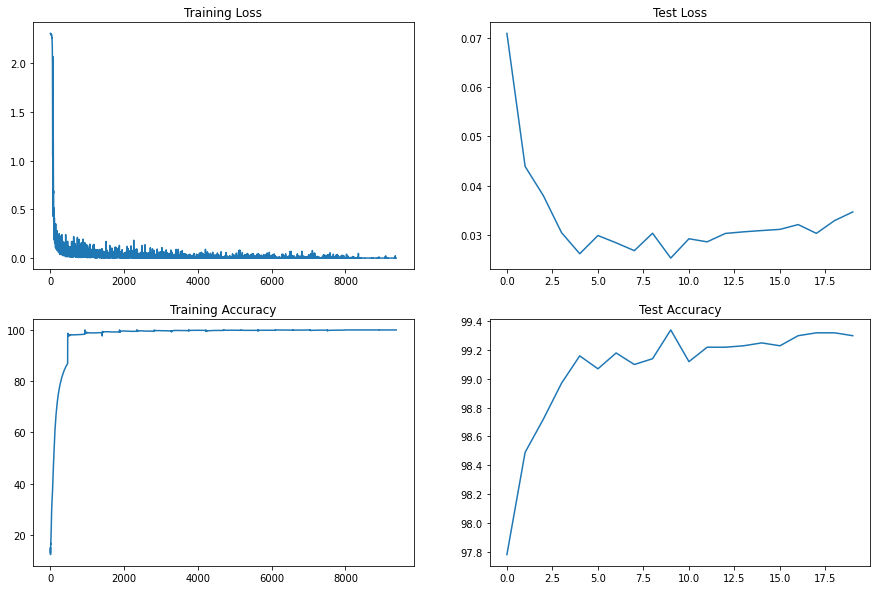

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Resuts
- parameters : >6M
- Best Training Accuracy: 99.99
- Best Test Accuracy: 99.30

Analysis
- we see the number of parameters is too high for our model. 
- As train Accuracy is more than test accuracy for a significant number of epochs we can observe that our model is overfitting. 